# Data Exploration

In [122]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyth.plugins.rtf15.reader import Rtf15Reader
from pyth.plugins.plaintext.writer import PlaintextWriter
import re

Importing Data Dictionary with pyth (https://pypi.org/project/pyth/)

In [123]:
os.listdir()

['data_dictionary.rtf',
 'airbnb_data_exploration.ipynb',
 'data_webvisits.txt',
 'readme.txt',
 '.ipynb_checkpoints']

In [124]:
filename = 'data_dictionary.rtf'

In [125]:
doc = Rtf15Reader.read(open(filename, "rb"))

In [126]:
text = PlaintextWriter.write(doc).getvalue()

In [127]:
#printing data dictionary:
#the last field contains attribute information:
print(re.sub(r"(\w)([A-Z])", r"\1 \2", text))

Column Type Null Partition Key Comment
id_visitorvarchartruefalseid of the visitor
id_sessionvarchartruefalseid of the session
dim_session_numberbiginttruefalsethe number of session on a given day for a visitor
dim_user_agentvarchartruefalseuser agent of the session
dim_device_app_combovarchartruefalseparsed out device/app combo from user agent
dsvarchartruefalsedate stamp of session
ts_minvarchartruefalsetime of session start
ts_maxvarchartruefalsetime of session end
did_searchbiginttruefalsebinary flag indicating if the visitor performed a search during the session
sent_messagebiginttruefalsebinary flag indicating if the visitor sent a message during the session
sent_booking_requestbiginttruefalsebinary flag indicating if the visitor sent a booking request during the session



In [128]:
df = pd.read_csv('data_webvisits.txt', sep='|')

In [129]:
df.columns

Index(['id_visitor', 'id_session', 'dim_session_number', 'dim_user_agent',
       'dim_device_app_combo', 'ds', 'ts_min', 'ts_max', 'did_search',
       'sent_message', 'sent_booking_request', 'next_id_session',
       'next_dim_session_number', 'next_dim_user_agent',
       'next_dim_device_app_combo', 'next_ds', 'next_ts_min', 'next_ts_max',
       'next_did_search', 'next_sent_message', 'next_sent_booking_request'],
      dtype='object')

In [130]:
df.dtypes

id_visitor                    object
id_session                    object
dim_session_number             int64
dim_user_agent                object
dim_device_app_combo          object
ds                            object
ts_min                        object
ts_max                        object
did_search                     int64
sent_message                   int64
sent_booking_request           int64
next_id_session               object
next_dim_session_number      float64
next_dim_user_agent           object
next_dim_device_app_combo     object
next_ds                       object
next_ts_min                   object
next_ts_max                   object
next_did_search              float64
next_sent_message            float64
next_sent_booking_request    float64
dtype: object

I will perform more data transformations later, but will make ds a timestamp immediately for convenience

In [131]:
df['ds'] = pd.to_datetime(df.ds)
df.ds.head()

0   2015-02-16
1   2015-02-18
2   2015-02-18
3   2015-02-18
4   2015-02-19
Name: ds, dtype: datetime64[ns]

Simple data checks to make sure I make the right assumptions about the data:

In [132]:
#Is each session unique? Is each instance representing a user session at the most granular level?
if len(df['id_session'].unique()) == len(df):
    print("Each Session is unique")

Each Session is unique


In [133]:
#Can visitors have multiple sessions i.e. is there a one to many relationship between user session and visitor id?
print("Number of unique users: ", len(df['id_visitor'].unique()))

Number of unique users:  630


In [134]:
#The dim_session_number field represents the number of session on a given day for a visitor"
#Does this mean that for each day, for each visitor, we have a count of all visitor sessions, at the time of the session?
#To verify, I track a given visitor id for a given day, and then for multiple days, and observe how dim_session_number varies
df[df['id_visitor'] == '0331fa39-455f-4f47-9db2-18ce37ee90e4'][['id_session','ds', 'dim_session_number']].sort_values('ds')

,id_session,ds,dim_session_number
3242,774ec118765237acf89c59ffda91b5f6,2014-06-26,1
3243,f2a22a7386a11d457ab12dd4fd7b1c32,2014-06-30,2
3244,b3587b80d73b3c432302d70f55fc0860,2014-07-01,3
3245,7aa5ed16004d96ac89f3151632032e95,2014-08-03,4
3246,3c9096b04413317dfac2664e13222ccb,2014-08-18,5
3248,16d7ae846f378ab6fc81c717fc621f04,2014-09-20,7
3247,75e94a24c7764d72429bd5f4bf955793,2014-09-20,6
3249,c400bcdda05546d01b78964fb984f718,2014-09-21,8
3250,298b4debffc0c6d1bad9fe9375e06aec,2014-09-30,9
3251,a3fa9ff9d230fe7167da68b0187d089e,2014-10-04,10


The above demonstrates that the dim_session_number attribute tracks the total count of sessions for a given visitor including the sessions occuring on the day of. The count does not reset for each day (we could probably create a feature for tracking the count for the same day).

For more info on user agents, visit: https://www.howtogeek.com/114937/htg-explains-whats-a-browser-user-agent/
The dataset contains two related fields: user_agent and dim_device_app_combo. The latter should be a parsed version of the former.

In [135]:
#picking a few random instances to see in more detail:
print('user agent: ', df.iloc[1,3])
print('--')
print('parsed out: ',df.iloc[1,4])
print('\n')
print('user agent: ',df.iloc[200,3])
print('--')
print('parsed out: ', df.iloc[200,4])
print('\n')
print('user agent: ',df.iloc[300,3])
print('--')
print('parsed out: ', df.iloc[300,4])

user agent:  Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/40.0.2214.115 Safari/537.36
--
parsed out:  Desktop - Chrome


user agent:  Mozilla/5.0 (Linux; Android 4.3; GT-I9505 Build/JSS15J) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.114 Mobile Safari/537.36
--
parsed out:  Android Phone - Web


user agent:  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/38.0.2125.122 Safari/537.36
--
parsed out:  Desktop - Chrome


The parsed out version of the field contains useful information, but it is possible to extract more e.g. OS, mobile device browser, browser versioin, etc. 

Next: is it possible to do request booking without doing a search and/or sending a message?

In [136]:
#Quick examination of remaining fields:
df_temp = df[['did_search', 'sent_message', 'sent_booking_request', 'id_visitor']].groupby(['id_visitor']).sum()

In [137]:
df_temp.loc[((df_temp['did_search'] == 0) & (df['sent_message'] == 1))|
        ((df_temp['did_search'] == 0) & (df['sent_booking_request'] == 1))]

,did_search,sent_message,sent_booking_request
id_visitor,,,


In [139]:
df_temp.loc[((df_temp['did_search'] == 0) & (df['sent_message'] == 1))]

,did_search,sent_message,sent_booking_request
id_visitor,,,


The above shows it is not possible to request a booking without ever having done a search. It is also showing that it is not possible to have sent out a message if the search has not been done. However, this does not imply that all  sessions that include a message must include a search as well. It just means that every customer must have initially have done a search in order to have sent a message.

In [138]:
print('Total Searches: ', sum([True for i in df.did_search if i == 1]))
print('Total Messages: ', sum([True for i in df.sent_message if i == 1]))

Total Searches:  1236
Total Messages:  1279


In [140]:
del df_temp

The above confirms that in order to have a sent message or a sent booking request, one must have made a search

#### Data Quality Checks:
    - how many nulls do we have
    - are min max timestamp values really what the data dictionary says?
    - is ts_min always less recent than ts_max?
    - do ts_min/max coherently reflect the ds field?

In [141]:
df.isnull().sum()

id_visitor                     0
id_session                     0
dim_session_number             0
dim_user_agent               219
dim_device_app_combo           0
ds                             0
ts_min                         0
ts_max                         0
did_search                     0
sent_message                   0
sent_booking_request           0
next_id_session              630
next_dim_session_number      630
next_dim_user_agent          829
next_dim_device_app_combo    630
next_ds                      630
next_ts_min                  630
next_ts_max                  630
next_did_search              630
next_sent_message            630
next_sent_booking_request    630
dtype: int64

Observations regarding nulls:
    - there are many nulls in the fields representing the next session. However, we will discard the fields when building the predictive model
    - if dim_device_app_combo is derived from dim_user_agent, how is it possible that the latter has 219 nulls while the former has none?

In [142]:
#Exploring instances where dim_user_agent is null:
df_nulls = df[(df['dim_user_agent'].isnull() == True)]

In [143]:
#Only two values for dim_device_app_combo are present when dim_user_agent is null
df_nulls.dim_device_app_combo.unique()

array(['Unknown - Moweb', 'Other - Other'], dtype=object)

In [144]:
max_dim_number = df_nulls[['id_visitor','dim_session_number', 'did_search']].groupby('id_visitor').max()

In [145]:
max_dim_number.reset_index(inplace=True)

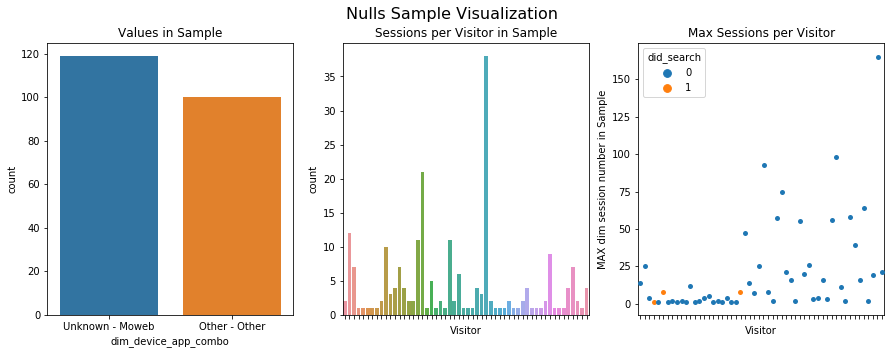

In [146]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

sns.countplot(df_nulls.dim_device_app_combo, ax=axes[0])
axes[0].set(title='Values in Sample')

sns.countplot(df_nulls.id_visitor, ax=axes[1])
axes[1].set(xlabel='Visitor', title='Sessions per Visitor in Sample')
axes[1].set_xticklabels([])

sns.stripplot(x ='id_visitor', y='dim_session_number' ,hue ='did_search' , data=max_dim_number, ax=axes[2])
axes[2].set(xlabel='Visitor', ylabel='MAX dim session number in Sample', title='Max Sessions per Visitor')
axes[2].set_xticklabels([])

#sns.(x, kde=False
plt.suptitle('Nulls Sample Visualization', fontsize=16)
plt.show()

Both values of dim_device_app_combo are well represented in the sample. The count of sessions per visitor is relatively low, with the majority of users never performing any searches. Roughly half the visitors had performed few sessions up to that point, while the other half had more.

In [147]:
print('Most recent instance among the nulls: ', df_nulls.ds.max())
print('Least recent instance among the nulls: ', df_nulls.ds.min())

Most recent instance among the nulls:  2014-10-22 00:00:00
Least recent instance among the nulls:  2014-05-13 00:00:00


It appears these 219 nulls occurred between a very small time frame: this is a useful insight. To see if all these nulls occurred in block, we can open up the dataframe's index and see if the values are sequential.

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


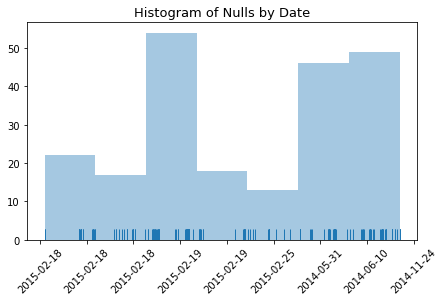

In [148]:
#df_nulls.index
fig, ax = plt.subplots(1,1,figsize=(7,4))
sns.distplot(df_nulls.index, kde=False, rug=True, ax=ax)
ax.set_xticklabels(df.ds.dt.date, rotation=45)
#ax.set(title=)
plt.title('Histogram of Nulls by Date', fontsize=13)
plt.show()

In [149]:
del df_nulls

In [150]:
df.columns

Index(['id_visitor', 'id_session', 'dim_session_number', 'dim_user_agent',
       'dim_device_app_combo', 'ds', 'ts_min', 'ts_max', 'did_search',
       'sent_message', 'sent_booking_request', 'next_id_session',
       'next_dim_session_number', 'next_dim_user_agent',
       'next_dim_device_app_combo', 'next_ds', 'next_ts_min', 'next_ts_max',
       'next_did_search', 'next_sent_message', 'next_sent_booking_request'],
      dtype='object')

There are no particular patterns related to these nulls and the dim_device_app_combo values confirm the session user agents were unknown or "other" so we will encode the nulls with the value of "unknown/other" and treat them as a valid category

In [151]:
df['dim_user_agent'].fillna("unknown/other", inplace=True)

Are ts min/max values between '2014-05-05', '2015-04-23'?

In [152]:
df.ts_min = pd.to_datetime(df.ts_min)
df.ts_max = pd.to_datetime(df.ts_max)

In [153]:
print('Most recent date: ', df.ts_min.dt.date.min())
print('Most recent date: ', df.ts_min.dt.date.max())

Most recent date:  2014-05-05
Most recent date:  2015-04-23


The dataset time range is correct. Are values in ts_min always older than values in ts.max?

In [154]:
if sum([True for i,k in zip(df.ts_min, df.ts_max) if i <= k]) == len(df):
    print('Values in ts_min are always less than or equal to values in ts_max')

Values in ts_min are always less than or equal to values in ts_max


Do ts_min and ts_max reflect ds correctly?

In [155]:
if sum([True for i,k,j in zip(df.ts_min, df.ts_max, df.ds) if (i.normalize() == j.normalize()) &
     (k.normalize() == j.normalize())]) != len(df):
    print('ts_min and ts_max not not reflect ds correctly')

ts_min and ts_max not not reflect ds correctly


In [156]:
df[(df.ts_max.dt.date!=df.ds.dt.date)&(df.ts_min.dt.date!=df.ds.dt.date)][['ts_min', 'ts_max', 'ds']]

,ts_min,ts_max,ds
1388,2015-01-12 00:14:39,2015-01-12 01:09:20,2015-01-11
1834,2015-01-04 00:14:58,2015-01-04 00:14:59,2015-01-03
2519,2014-08-05 00:30:59,2014-08-05 00:32:13,2014-08-04
2520,2014-08-05 00:28:06,2014-08-05 00:30:56,2014-08-04
2540,2014-08-05 00:28:05,2014-08-05 00:32:15,2014-08-04
2645,2015-02-02 00:11:00,2015-02-02 00:21:07,2015-02-01
2647,2015-02-02 00:25:36,2015-02-02 00:25:36,2015-02-01
2648,2015-02-02 00:39:02,2015-02-02 01:16:49,2015-02-01
2653,2015-02-03 01:17:56,2015-02-03 01:21:22,2015-02-02
2654,2015-02-03 01:41:54,2015-02-03 01:52:21,2015-02-02


It looks like in a few cases the timesetamp did not get recorded correctly. We will correct these instances now:

In [157]:
ix = df[(df.ts_max.dt.date!=df.ds.dt.date)&(df.ts_min.dt.date!=df.ds.dt.date)][['ts_min', 'ts_max', 'ds']].index

In [158]:
df1 = df[(df.ts_max.dt.date!=df.ds.dt.date)&(df.ts_min.dt.date!=df.ds.dt.date)][['ts_min', 'ts_max', 'ds']]

In [159]:
df.loc[ix,'ds'] = df.loc[ix,'ds'].apply(lambda x: x.normalize() + pd.Timedelta(days=1))

In [160]:
df[(df.ts_max.dt.date!=df.ds.dt.date)&(df.ts_min.dt.date!=df.ds.dt.date)][['ts_min', 'ts_max', 'ds']]

,ts_min,ts_max,ds


The problem has been corrected

##### Next, we move on from data quality checks to data visualizations that should give us more insight

In [161]:
df.dtypes

id_visitor                           object
id_session                           object
dim_session_number                    int64
dim_user_agent                       object
dim_device_app_combo                 object
ds                           datetime64[ns]
ts_min                       datetime64[ns]
ts_max                       datetime64[ns]
did_search                            int64
sent_message                          int64
sent_booking_request                  int64
next_id_session                      object
next_dim_session_number             float64
next_dim_user_agent                  object
next_dim_device_app_combo            object
next_ds                              object
next_ts_min                          object
next_ts_max                          object
next_did_search                     float64
next_sent_message                   float64
next_sent_booking_request           float64
dtype: object

In [162]:
ax1_df = pd.melt(df[['sent_booking_request', 'sent_message', 'did_search']])

In [198]:
#technically, the max corresponds to the count when it comes to dim_session_number
ax2_df = df[['id_visitor', 'dim_session_number', 'sent_booking_request']].groupby(['id_visitor']).max()
ax2_df.reset_index(inplace=True)

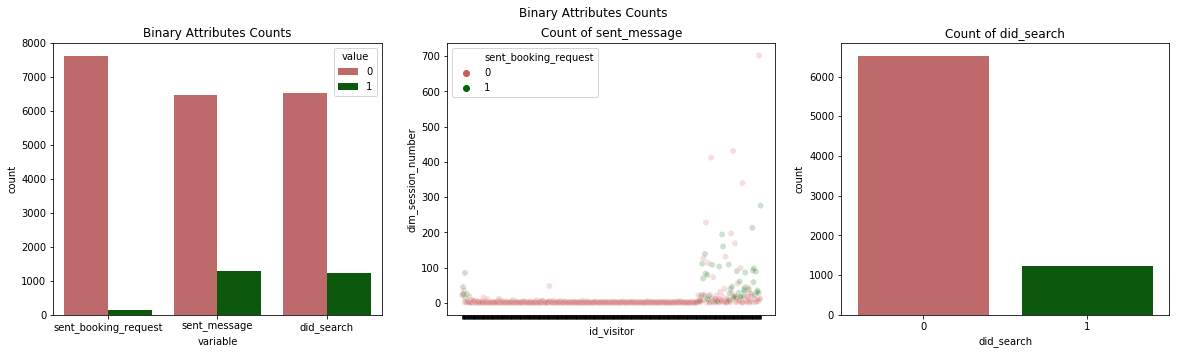

In [207]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

sns.countplot(x="variable", hue="value", 
              data=ax1_df, ax=ax1, palette=["indianred", "darkgreen"])
ax1.set(title='Binary Attributes Counts')

sns.scatterplot(x = 'id_visitor', y = 'dim_session_number', hue = 'sent_booking_request',
                alpha = 0.2, data=ax2_df, ax=ax2, palette=["indianred", "darkgreen"])
ax2.set(title='Count of sent_message')
ax2.set_xticklabels([])

sns.countplot(df.did_search, ax=ax3, palette=["indianred", "darkgreen"])
ax3.set(title='Count of did_search')

plt.suptitle('Binary Attributes Counts')

plt.show()

In [ ]:
#next do:
#average number of searches and or messages before request sent + stdev
#timeseries: group by searches and or messages and or requests with month
#parse dim_device_app_combo into two and plot it

### Problem statement: predict whether if user sends a booking request based on 